##### <font color="C13F38"><strong>This homework is due at midnight on April 21, 2023. </strong></font>

Run the cell below to get started.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import lognorm, ttest_ind

# Lab 4

Lab 4 consists of two parts.

In the first part of this lab (this one!), you will write a simple version of the drift diffusion model, and simulate the speed-accuracy tradeoff, the relationship between an individual’s willingness to respond slowly and make fewer errors on a task, compared to their willingness to respond quickly but also make relatively more errors. You will also inspect the response time distributions for correct and incorrect trials that are generated by these simulations. Next, you will implement a version of the drift diffusion model where the urge to respond grows over time (e.g., you will implement the “collapsing” bounds that we talked about during class). 

In thse second part, you are going to explore an “attentional” drift diffusion model, that was designed to explain how people choose between different food options, and that assumes that this choice is dependent on which items you focus your attention.

There are 26 points to earn in the first part, and 35 points in the second. This means that you can earn 59 points in total.

_Credits_
I thank Ian Krajbich for so generously sharing his code and materials. The second section of this lab draws on work from the following publication:

Krajbich, I., Armel, C., & Rangel, A. (2010). Visual fixations and the computation and comparison of value in simple choice. _Nature Neuroscience, 13_, 1292-1298.

# 1. The drift diffusion model


In 1868, Franciscus Donders was the first to measure some aspect of cognition, a simple decision, with response times. There were two conditions in his experiment. On some trials, people simply had to press a lever when a light came on. On other trials, they had to indicate which of two lights came on, by pressing one of two levers. He reasoned that by measuring the the difference in response time between these two conditions, he could measure how the cognitive process of making a decision!

This was quite a revolutionary insight, because till this day reaction times are the most used measurement in cognitive psychology. So, it shouldn’t come as a surprise that psychologists have been trying to use computational modeling to simulate response times for a very long time. As you learned in class, the most successful attempt at this is the _drift diffusion model_.

## The dot motion coherence task

Classically, the drift diffusion model has been studied using the dot motion coherence task. As you will recall from class, on each trial view a bunch of dots moving around on the screen. Some of these dots are moving in random directions, but a certain portion of dots are moving in the same direction (say left or right). The participant has to indicate in which direction the coherent dots are moving. Sometimes, trials are easy, and most or all dots move in the same direction. For example, this an example of a trial with all dots moving to the right (100% coherence):

![dot-motion1](dot-motion1.png)

Other times, trials are hard, only a few dots move in the same direction. For example, this is an example of a trial with 30% of the dots moving to the left (30% coherence):

![dot-motion2](dot-motion2.png)

People’s behavior on this task is not particularly surprising. People are more likely to respond in the direction in which the dots are moving. Sometimes they respond incorrectly. When there is a smaller proportion of coherent dots in the display, people are slower and less accurate to respond. Here is some data from monkeys performing this task, as collected by Palmer and colleagues (2005), to demonstrate this point:

![palmer](palmer-2005.png)


Moreover, there is considerable variability in how long it takes a single participant to respond, and how accurate that response is: for the same coherence level, sometimes they are slow, other times they are fast. Finally, it turns out that this task captures the speed-accuracy tradeoff, the relationship between an individual’s willingness to respond slowly and make fewer errors on a task, compared to their willingness to respond quickly but also make relatively more errors, quite well. If you ask people to focus on responding accurately, they will do so but also respond slower. On the other hand, if you ask them to focus on responding quickly, they will become less accurate. Here is some data from Mulder et al. (2013) that demonstrates this point. They instructed two participants to do a dot motion task under these two instruction conditions. How can you see the speed-accuracy tradeoff?

![mulder](mulder-2013.png)

We are going to model all these aspects of the task (and more) using the _drift diffusion model_.

## The model
Developed in 1978 by Roger Ratcliff, the drift diffusion model is, in essence, a simple extension of the sequential probability ratio test. The main idea is that when the brain has to decide between two options, it continually collects evidence from the environment, and then slowly accumulates this evidence over time. Once the accumulated evidence is strong enough, the decision is made and the accumulation process is terminated. The response time is simply how long it took for this process to end.

So, how does this model explain that there is considerable variability in how long it takes for a single person to respond on a set of trials? Well, the drift diffusion model assumes that each time the observer gets some evidence, there is some noise added to this evidence. So, even though the actual evidence stays the same throughout the trial (there is always a fixed proportion of coherent dots moving in the same direction), this noise may sometimes bump the accumulation towards the incorrect response. You saw this in class already a few times, but this is a picture of the drift diffusion model on a single trial:

![cartoon](ddm-cartoon.png)

Of course, this course is called computational cognitive psychology, so let’s get a bit more formal about the math behind the model. At the start of the trial (time step $t = 0$), we are
assuming that the accumulated evidence, or the decision variable, $V_{t=0} = 0$. The model accumulates evidence $e_t$ on each time step $t$, changing $V_t$, so that the decision variable on the next time step ($V_{t+1}$) becomes:

$V_{t+1} = V_t + d \cdot e_t + \epsilon_t$

with $d$ being the drift rate, which is a constant that controls he speed with which the information is integrated (like the learning rate $\alpha$ in reinforcement learning models), and $\epsilon_t$ being the ‘noise’. This is a value that gets randomly drawn from a normal distribution with some standard deviation $\sigma$ and mean 0.

In most tasks, the evidence $e$ is the same across all timesteps of a single trial. For example, in the dot motion coherence task above, the _proportion_ of dots moving in the same direction doesn’t change. So, if we just change $V$ as a function of the evidence, it will always shoot straight to right answer. So, only the noise is going to make the decision variable sometimes go away from the right answer. Conceptually, you can think of this noise as representing lapses in attention, variability in the environment, or even just some of the noise inherent to the brain’s information processing pathways.

The system keeps accruing evidence, until the decision variable $V$ crosses a positive threshold $A$ or the negative version of this threshold $-A$. We map these thresholds to the two responses. For example, we can say that whenever $V_t > A$, the model responds with "left", and when $V_t < -A$, the model responds with "right"

After this, the reaction time on the current trial will be equal to the final timestep $t$, plus some constant that constitutes the non-decision time $\tau$, representing any processes that take time, but that are not related to making a decision (for example, propagating of neural activity from retina to visual cortex, or sending the final decision to motor cortex in order to press the button).

## Simulating the drift diffusion model in Python

Great, with the formal details out of the way, let’s get ready to code this model up. With all the coding experience of last weeks behind you, I think you will find this pretty straightforward!

You are going to finish `ddm_trial_tobefinished` (and give it a better name!). This is going to be a function that runs a single trial of the drift diffusion model. Its input parameters will be the evidence $e$, the drift rate $d$, the standard deviation of the noise $\sigma$, a vector with the thresholds $[A, -A]$, the non-decision time $\tau$ (tau). You will want it to return an output dictionary with several fields: a variable with the reaction time `rt`, a variable with the choice choice, a vector `V` that contains the decision value over time, and a variable with the accuracy `accuracy`. Note that `accuracy` should be 1 if the evidence and the answer have the same sign, and 0 otherwise (for example, if the evidence is 0.2, but the final answer hit the negative threshold, then the answer is not correct).

In [2]:
# finish the following and rename
def ddm_trial(evidence, drift_rate, noise_std, threshold, tau):# add correct arguments
    V = 0
    V_store=[]
    trial = {}
    t = 0
    Apos=threshold[1]
    Aneg=threshold[0]    
    accuracy=0
    choice=0
    
    while  (abs(V)<Apos): # add correct condition
      noise=np.random.normal(0,noise_std)
      V=V+drift_rate*evidence+noise
      V_store.append(V)
      rt=tau+t
      t=t+1
    if V>0:
      choice=1
    else:
      choice=-1
    if choice*evidence>0:
        accuracy=1
    else:
        accuracy=0

    trial = {'rt': rt,'V': V,'choice': choice, 'accuracy': accuracy, 't':t }
    #trial['V'] = V# make sure that V contains all values of the decision variable over time
    #trial['rt']=rt
    #trial['accuracy'] # save the rest of the results in the dictionary 
    # return trial
    return trial, V_store

<font color="508C46"><strong>Question 1 (6 points)</strong> <br>
Finish `ddm_trial_tobefinished`. You’ll notice that this function is set up to use a `while` loop. Refresh your mind on what a `while` loop does, and then think about what the right stopping condition is. If you don’t understand while loops, do some research! Do not forge ahead without understanding them. Hint: you will also want to draw random normal noise at some point in this function.
</u></b></font>

<font color="508C46"><strong>Question 2 (2 points)</strong> <br>
Simulate a trial on this task, using `e=0.3`, `d=0.01`, `sigma=0.1`, `tau=50`, and `bounds=[-1, 1]`. Show us a plot of `V` over time. It will be informative if you plot the thresholds in this plot with `plt.axhline`. <u>**Was the response accurate (how do you know)? What was the RT (how do you know)?**</u>
</u></b></font>

1


144

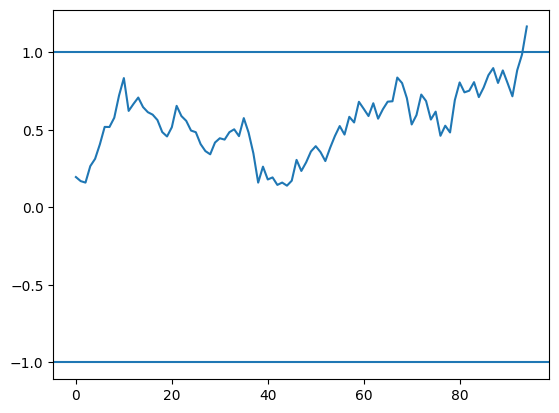

In [10]:
# your code here
test,v =ddm_trial(.3,.01,.1,[-1,1],50)
plt.plot(v)
plt.axhline(y=1)
plt.axhline(y=-1)
print(test['accuracy'])
test['rt']


.. double click this to write your response.

Because of the randomization in the error, response accuracy changes each time the function is run. However, when accuracy gets printed out as 0, the response was incorrect and when it's 1 it is correct. Similarly, rt is different each time the function gets called but in the instance I am looking at, RT is 144 ms and the response was accurate. 

<font color="508C46"><strong>Question 3 (3 points)</strong> <br>
Write a new function that uses `ddm_trial` and that lets you generate multiple trials (`nrtrials`) of the drift diffusion model with the same input variables (e, d, `sigma`, `tau`, and `bounds`). The output of this function should return the reaction time and the accuracy of each trial of the simulation. Using this function, investigate the effect of evidence strength on behavior (use at least 1000 trials). Specifically, use this function to conceptually (not precisely) replicate the findings depicted in the figure from Palmer and colleagues on page 2. Note that the values for the evidence $e$ do not have to be identical to those in the x-axis of the figure. <u>**In other words, investigate how varying the strength of the evidence influences behavior of the drift diffusion model. Describe what you find.**</u>
</u></b></font>

In [4]:
# your code here
def ddm_simulate(evidence, drift_rate, noise_std, bounds, tau, nrtrials): # continue here
  rt=np.zeros(nrtrials)
  accuracy=np.zeros(nrtrials)
  for trial in range(nrtrials):
    trial_,V=ddm_trial(evidence, drift_rate, noise_std,bounds,tau)
    rt[trial]=trial_['rt']
    accuracy[trial]=trial_['accuracy']


  return rt, accuracy


Text(0, 0.5, 'rt')

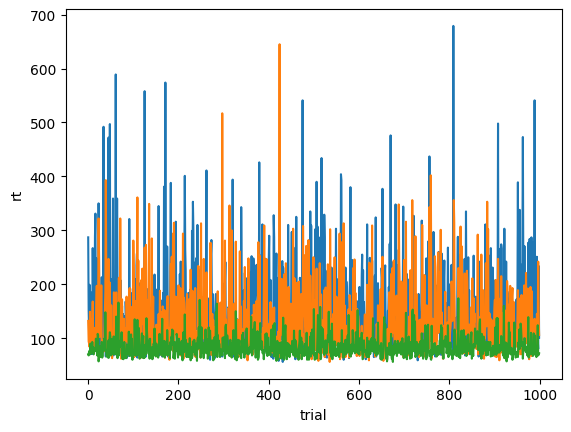

In [5]:
rt_lowev, accuracy_lowev=ddm_simulate(.1,.01,.1,[-1,1],50, 1000)
rt_midev, accuracy_midev=ddm_simulate(1,.01,.1,[-1,1],50, 1000)
rt_highev, accuracy_highev=ddm_simulate(3,.01,.1,[-1,1],50, 1000)

plt.plot(rt_lowev)
plt.plot(rt_midev)
plt.plot(rt_highev)
plt.xlabel('trial')
plt.ylabel('rt')


Text(0, 0.5, 'average accuracy')

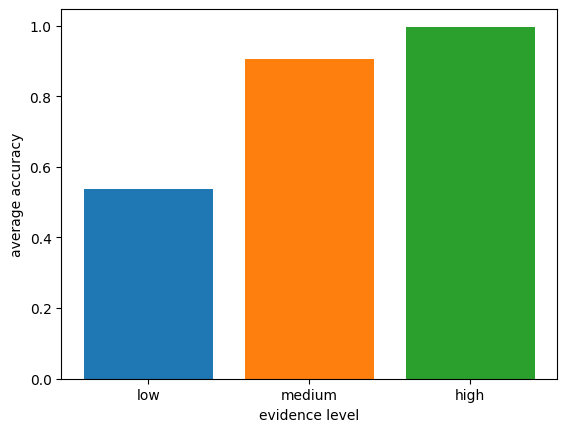

In [ ]:
plt.bar('low',np.average(accuracy_lowev))
plt.bar('medium',np.average(accuracy_midev))
plt.bar('high',np.average(accuracy_highev))
plt.xlabel('evidence level')
plt.ylabel('average accuracy')


.. double click this to type your response.

The first graph illustrates reaction times for tirals with different evidence strength. The green, which corresponds to the highest evidence has the shortest reacion times. Blue and orange are low and medium evidence respectively. the longest reaction time corresponds with the lowest evidence. Accuracy shows a similar intutive trend where high evidence corresponds with high average accuracy while low evidence yields less accurate responses. 

## Speed accuracy tradeoff

In 1998, Ratcliff and Rouder demonstrated that the speed-accuracy tradeoff, the inherent competition between fast vs accurate responding, can be easily explained using the drift diffusion model. They argue that, when accuracy is emphasized, the increased caution that people have in responding can be modeled by making the decision thresholds move further away from the starting point (further away from zero). Let’s see whether you can as well!


<font color="508C46"><strong>Question 4 (3 points)</strong> <br>
Use the function from the previous question, and conceptually replicate the results from the Mulder et al. (2013) on page 3. That is, show that by increasing the decision threshold, the drift diffusion model becomes slower and more accurate. Also, show that by decreasing the threshold, the drift diffusion model becomes faster but also less accurate. <u>**Report your results in graphs, and describe what you see.**</u>
</u></b></font>

In [11]:
# your code here
rt_highthresh, accuracy_highthresh=ddm_simulate(.1,.01,.1,[-10,10],50, 1000)
rt_midthresh, accuracy_midthresh=ddm_simulate(.1,.01,.1,[-5,5],50, 1000)
rt_lowthresh, accuracy_lowthresh=ddm_simulate(.1,.01,.1,[-1,1],50, 1000)


<BarContainer object of 1 artists>

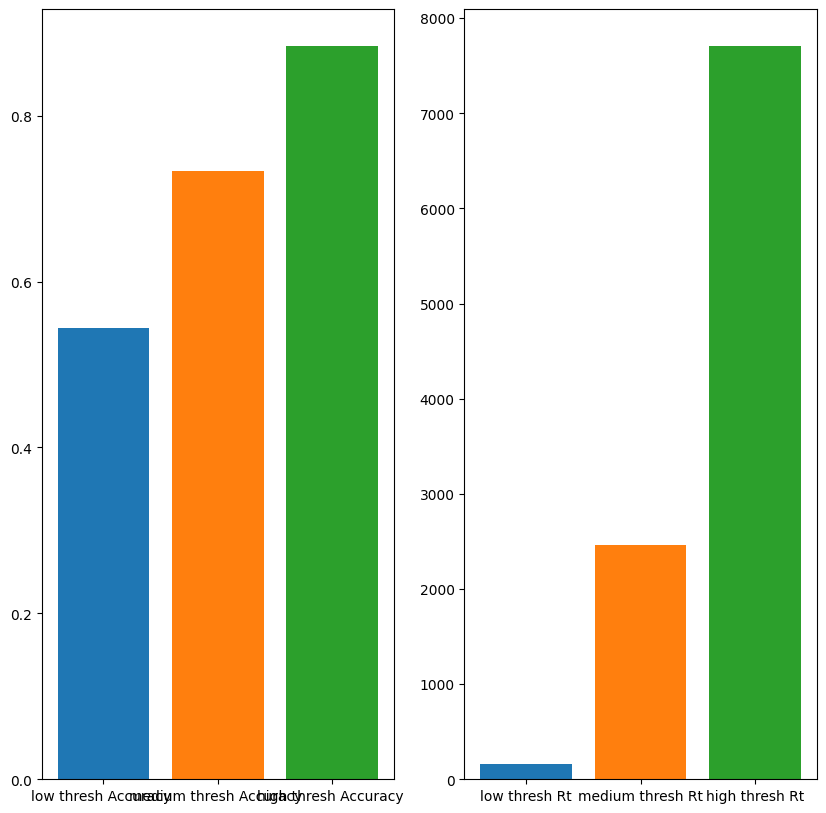

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].bar('low thresh Accuracy ', np.average(accuracy_lowthresh))
ax[1].bar('low thresh Rt', np.average(rt_lowthresh))
ax[0].bar('medium thresh Accuracy ', np.average(accuracy_midthresh))
ax[1].bar('medium thresh Rt', np.average(rt_midthresh))
ax[0].bar('high thresh Accuracy ', np.average(accuracy_highthresh))
ax[1].bar('high thresh Rt', np.average(rt_highthresh))




.. double click this to type your response.

## Comparing RT distributions
One interesting aspect from the drift diffusion model is that distributions of reaction times from inaccurate and accurate trials are _identical_.

<font color="508C46"><strong>Question 5 (2 points)</strong> <br>
Use `scipy.stats` statistical functions to show that this is true for a few evidence strength values of the DDM <u>**Show your work.**</u>
</u></b></font>

In [24]:
# your code here
#low evidence
rt_lowev_accurate=[]
rt_lowev_inaccurate=[]

rt_, accuracy_lowev=ddm_simulate(.1,.01,.1,[-1,1],50, 1000)

for i in range(1000):
  if accuracy_lowev[i]==1:
    rt_lowev_accurate.append(rt_[i])
  else:
    rt_lowev_inaccurate.append(rt_[i])

#middle evidence 
rt_midev_accurate=[]
rt_midev_inaccurate=[]

rt_midev, accuracy_midev=ddm_simulate(1,.01,.1,[-1,1],50, 1000)

for i in range(1000):
  if accuracy_midev[i]==1:
    rt_midev_accurate.append(rt_[i])
  else:
    rt_midev_inaccurate.append(rt_[i])

#strong evidence 
rt_highev_accurate=[]
rt_highev_inaccurate=[]

rt_highev, accuracy_highev=ddm_simulate(3,.01,.1,[-1,1],50, 1000)

for i in range(1000):
  if accuracy_highev[i]==1:
    rt_highev_accurate.append(rt_[i])
  else:
    rt_highev_inaccurate.append(rt_[i])

print(ttest_ind(rt_lowev_accurate, rt_lowev_inaccurate))
print(ttest_ind(rt_midev_accurate, rt_midev_inaccurate))
print(ttest_ind(rt_highev_accurate, rt_highev_inaccurate))



Ttest_indResult(statistic=-0.17914606037807057, pvalue=0.8578593782912314)
Ttest_indResult(statistic=1.6393636809610275, pvalue=0.1014526993804492)
Ttest_indResult(statistic=nan, pvalue=nan)


<ipython-input-24-292a51eb8f76>:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(ttest_ind(rt_highev_accurate, rt_highev_inaccurate))


.. double click this to type your response.

Here we collect reaction times separately for accurate and inaccurate trials and compare them against each other using an independent samples ttest. There is no significant difference in reaction times across various evidence levels, showing that the distribution of RTs is unaffected by whether or not the trial was accurate

## ‘Collapsing’ bounds
Of course, actual behavior on two-alternative choice decision-making tasks suggests that reaction time performance on incorrect and correct trials is not identical. For example, Churchland and and colleagues (2008) found that the monkeys that performed the dot motion coherence task were slower on incorrect trials versus correct trials:

![churchland](churchland-2008.png)


If you compare this to the results from Question 5, you should notice that these data are quite different! The correct and incorrect trials have a different response time!

So, Churchland and colleagues reasoned that they needed to change their implementation of the drift diffusion model. They opted to do so by including “collapsing” boundary thresholds, that is, decision boundaries that converge over time during a trial, so that later in the trial less evidence is required to yield a response. A popular, and very flexible, choice for collapsing bounds uses the Weibull cumulative distribution function, which was originally used to describe particle size distribution in powder or granular material. Here, we will not be using it to calculate probabilities, but simply because its mathematical shape lets you gradually move from one boundary to next:

![collapsing](collapsing_bounds.png)

Churchland and colleagues found that by including these collapsing bounds, their model showed different behavior on the incorrect and correct trials! Let’s try it out.

The upper threshold at time $t$ from this mathematical formulation is given by:

$u(t) = A - (1 - e^{-(\frac{t}{\lambda})^k})(A-A')$

where $t$ is the time in the trial, $A>0$ is the starting threshold, $A' > 0$ is the asymptotic boundary of the second threshold $\lambda$, the "scale parameter, which stretches out the function so that it collapses later in time, and a "shape" parameter $k$, which dictates the slop of the decay. The lower bound then becomes the negative of the upper bound: $l(t) = -u(t)$.



<font color="508C46"><strong>Question 6 (5 points)</strong> <br>
Adapt the function from Questions 1 and 3 so that you can generate many trials of a drift diffusion model with collapsing boundaries. Make sure you save the values of the boundaries on each trial, <u>**so that you can show us that you did this successfully by plotting the development of the decision value of a certain trial along with the collapsing decision boundaries.**</u>
</u></b></font>

In [25]:
def ddm_cb_trial(evidence, driftRate, noise_SD, A, A_prime, tau, lamby, k):# add correct arguments
    t=0
    upper_T = A - (1-np.exp((-(t/lamby)**k)))*(A-A_prime)
    lower_T = -(upper_T)
    V = [0]
    vStore = []
    upperBounds = []
    lowerBounds = []
    trial = {} #rt, choice, v[], accuracy (0 or 1)
    rt = 0
    while abs(V[0]) < upper_T: 
      upper_T = A - (1-np.exp((-(t/lamby)**k)))*(A-A_prime)
      noise = np.random.normal(0,noise_SD)
      V[0] = V[0] + driftRate * evidence + noise # make sure that V contains all values of the decision variable over time
      vStore.append(V[0])
      upperBounds.append(upper_T)
      lowerBounds.append(-upper_T)
      rt = t + tau
      t += 1

    if V[0] > 0:
      choice = 1
    else:
      choice = -1
    if choice * evidence > 0:
      accuracy = 1
    else:
      accuracy = 0

    trial = {'rt': rt,'V': vStore,'choice': choice, 'accuracy': accuracy, 'upperBounds': upperBounds, 'lowerBounds': lowerBounds } # save the rest of the results in the dictionary 
    return trial

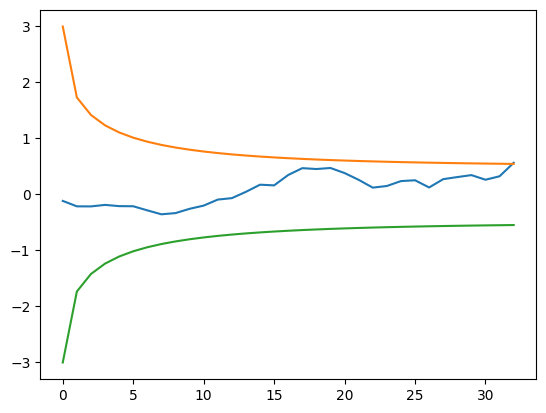

In [26]:
trial = ddm_cb_trial(0.3,0.01,0.1,3,0.5,50,2,.5)
plt.plot(trial['V'])
plt.plot(trial['upperBounds'])
plt.plot(trial['lowerBounds'])


.. double click this to type your response

The graph shows that V reaches the collapsing boundaries over time!

<font color="508C46"><strong>Question 7 (3 points)</strong> <br>
Now, write a new function that lets you collect many trials of the DDM with collapsing bounds (mirroring Question 3). <u>**Use this function to show that the collapsing bounds make reaction times on correct trials higher than on correct trials.**</u> Of course, there are many parameter values that you could use, so to make your search a bit easier, here values for the drift diffusion model that worked well for me: $e = 1$, $d = 0.001$ , $\sigma = 0.02$, and $\tau = 0$ (so skip the non-decision time for now). You will need to find parameter values for the collapsing bounds function that have the bounds collapse at a reasonable time so that there is enough ‘space’ to test whether the model produces the right behavior. An intuitive way to think of the lambda is that it roughly captures (in ms) *when* the bounds are collapsed (this is not 100% correct, but it will give you a sense of where to start looking).
</u></b></font>

In [32]:
def ddm_cb_simulate(evidence, drift_rate, noise_std, A, Aprime, lamby, k, tau, nrtrials): # add correct arguments
     
  rt=np.zeros(nrtrials)
  accuracy=np.zeros(nrtrials)
  upperBounds=[]
  lowerBounds=[]
  for trial in range(0,nrtrials):
    trial_=ddm_cb_trial(evidence, drift_rate, noise_std,A, Aprime, lamby, k, tau)
    rt[trial]=trial_['rt']
    accuracy[trial]=trial_['accuracy']
    upperBounds = trial_['upperBounds']
    lowerBounds = trial_['lowerBounds']

  return rt, accuracy, upperBounds, lowerBounds
    

In [39]:
rt,accuracy,upper_bounds, lower_bounds = ddm_cb_simulate(1, .001, .02, 2, .5, 1, 1, 0, 1000)
rt_accurate=[]
rt_inaccurate=[]
for i in range(1000):
  if accuracy[i]==1:
    rt_accurate.append(rt[i])
  else: 
    rt_inaccurate.append(rt[i])

print(np.average(rt_accurate))
print(np.average(rt_inaccurate)) 

1025.6412060301507
918.2


<font color="508C46"><strong>Question 8 (2 points)</strong> <br>
<u>**Explain why the collapsing choice boundaries lead to a difference in reaction time between incorrect and correct trials.**</u>
</u></b></font>


.. double click this to type your answer 

The collapsing boundaries allow for the speed / accuracy trade off which makes it such that longer time is spent trying to identify the correct answer. conversley, if the aim were to answer as quickly as possible, accuracy would be compamised. Mathematically, this is because the bounds converge earlier on and less evidence is needed for a decision to be made. The quicker this happens, the more likely it is for a response to be wrong while if it takes longer (i.e bigger bounds) , RT are longer but accuracy is also more likely.